# EDA-Gram


In [1]:
import os
import pandas as pd
import numpy as np
import pyphysio as ph
import matplotlib.pyplot as plt
from scipy import signal, fft
import pyphysio.estimators.Estimators as est
import pyphysio.filters.Filters as flt
from tqdm import tqdm

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


### Estrazione della parte Phasic dal segnale iniziale

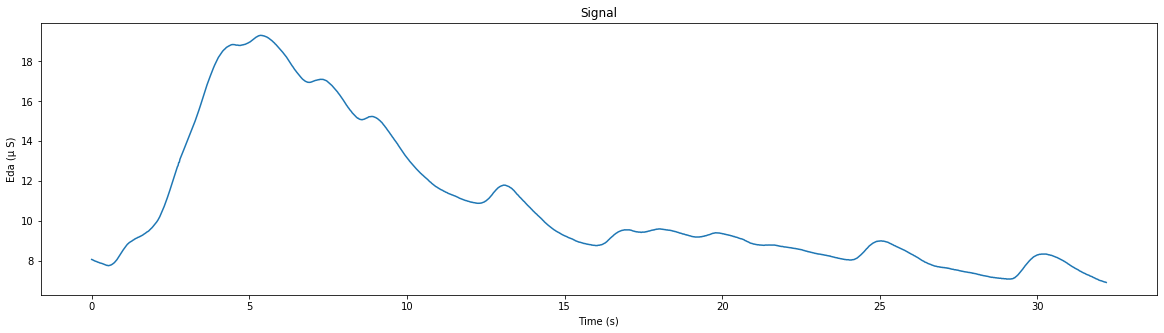

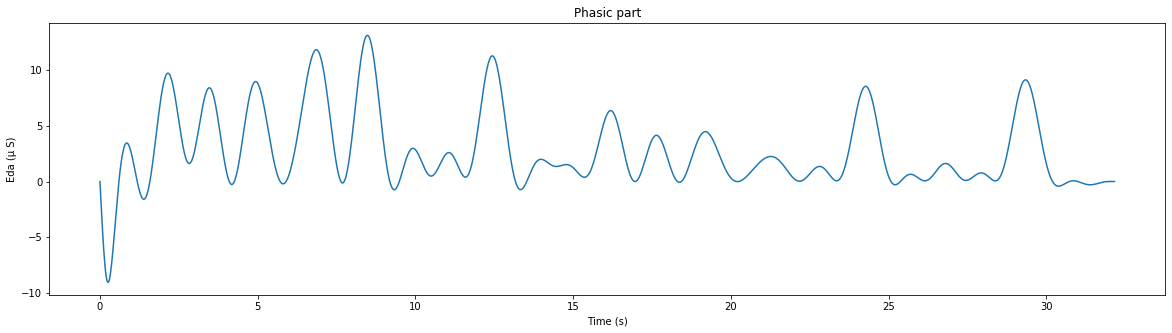

In [2]:
# prendo i dati eda di un soggetto e tengo la parte phasic

data = pd.read_csv('/Users/gioelepozzi/Desktop/PMEmo/code/eda_gram/1_EDA.csv', header=None)

subject = data.loc[0,1] # primo soggetto
signal = [] # vettore con i valori eda del primo soggetto
a = data.iloc[:,1]
for k in range(1,len(a)):
    signal.append(a[k])

fs = 50

# trasformazione del segnale per la libreria    
signal_p = ph.EvenlySignal(values = signal, sampling_freq = fs, signal_type = 'eda')

t = np.arange(0, len(signal_p), 1)/fs

plt.figure(figsize=(20,5))
plt.title('Signal')
plt.xlabel('Time (s)')
plt.ylabel('Eda (\u03BC S)')
plt.plot(t, signal_p)

# filtering
signal_filt = flt.IIRFilter(fp=0.8, fs = 1.1, ftype='ellip')(signal_p)

# phasic extraction
driver = est.DriverEstim()(signal_filt)
phasic, tonic, _ = ph.PhasicEstim(delta=0.02)(driver)

t_ = np.arange(0, len(phasic), 1)/fs

plt.figure(figsize=(20,5))
plt.title('Phasic part')
plt.xlabel('Time (s)')
plt.ylabel('Eda (\u03BC S)')
plt.plot(t_, phasic)

plt.show()

### Spettrogramma della parte phasic

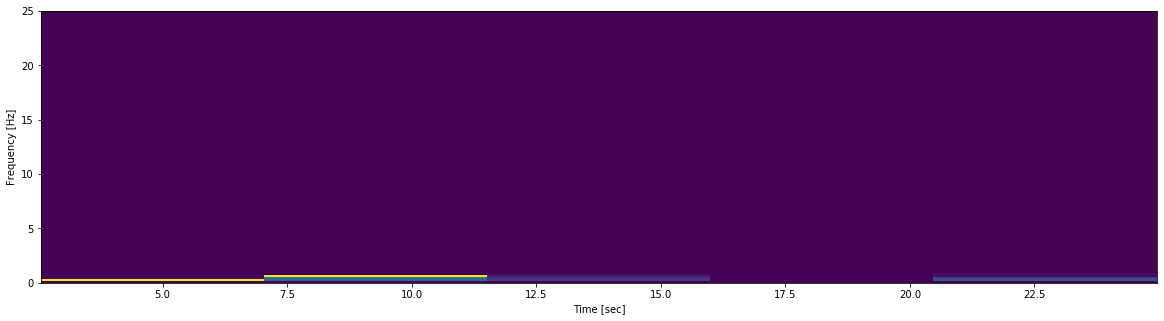

In [7]:
x = np.asarray(phasic) # rendere phasic un numpy array

f, t, Sxx = signal.spectrogram(x, fs)

plt.figure(figsize=(20,5))
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

### Spettro della parte phasic del segnale

Text(0, 0.5, '|X(freq)|')

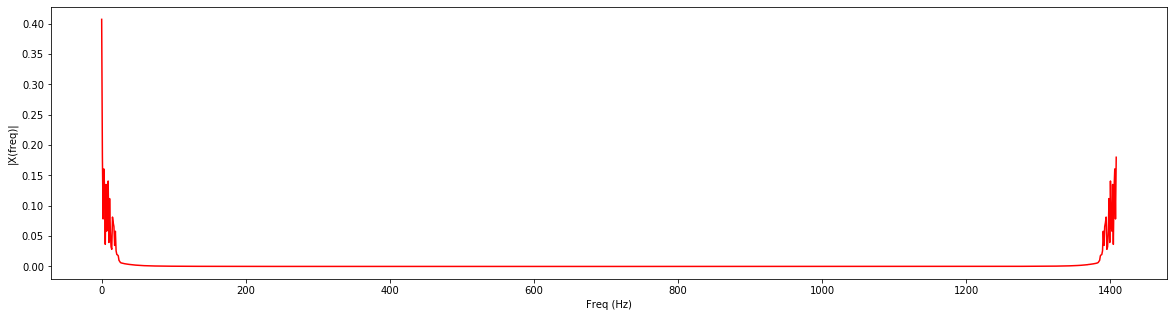

In [8]:
X = fft(x)/len(x)
plt.figure(figsize=(20,5))
plt.plot(abs(X),'r')
plt.xlabel('Freq (Hz)')
plt.ylabel('|X(freq)|')

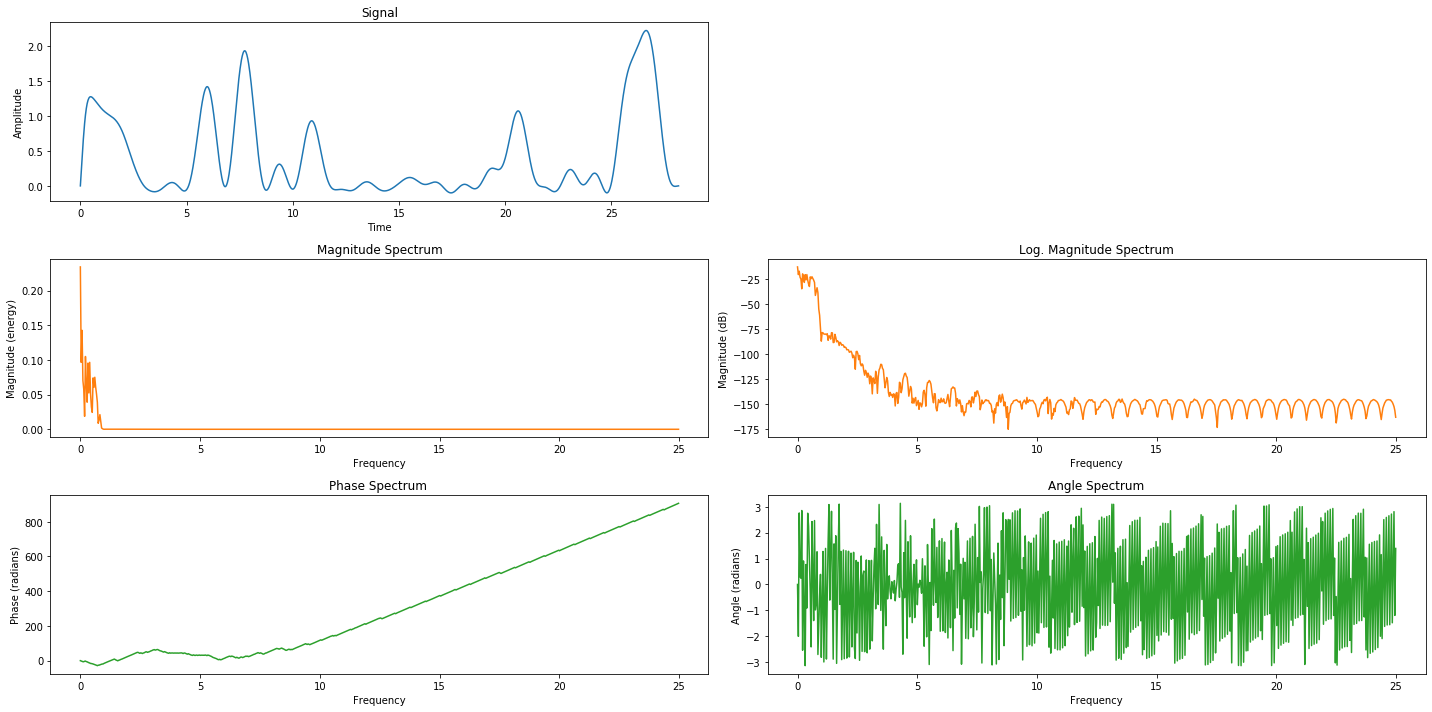

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))

# plot time signal:
axes[0, 0].set_title("Signal")
axes[0, 0].plot(t_, x, color='C0')
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Amplitude")

# plot different spectrum types:
axes[1, 0].set_title("Magnitude Spectrum")
axes[1, 0].magnitude_spectrum(x, Fs=fs, color='C1')

axes[1, 1].set_title("Log. Magnitude Spectrum")
axes[1, 1].magnitude_spectrum(x, Fs=fs, scale='dB', color='C1')

axes[2, 0].set_title("Phase Spectrum ")
axes[2, 0].phase_spectrum(x, Fs=fs, color='C2')

axes[2, 1].set_title("Angle Spectrum")
axes[2, 1].angle_spectrum(x, Fs=fs, color='C2')

axes[0, 1].remove()  # don't display empty ax

fig.tight_layout()
plt.show()

# Peak

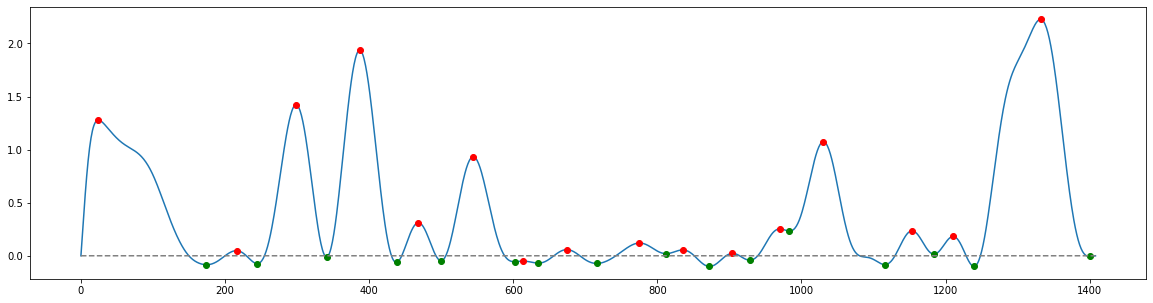

In [11]:
# Peak finder
from scipy.signal import find_peaks, peak_widths, argrelmin, argrelextrema

peaks, _ = find_peaks(phasic)
neg_peaks, _ = find_peaks(-phasic)

plt.figure(figsize=(20,5))
plt.plot(x)
plt.plot(peaks, x[peaks], "o", color='r')
plt.plot(neg_peaks, x[neg_peaks], "o", color='g')
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

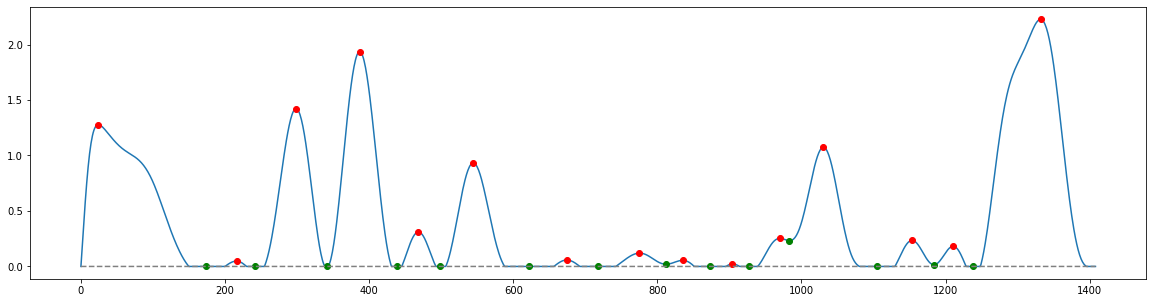

In [13]:
# tengo solo la parte positiva, può avere senso?
x[x < 0] = 0

# scelta dei picchi significativi?

peaks, _ = find_peaks(x, distance = 20)
neg_peaks, _ = find_peaks(-x, distance = 20)


plt.figure(figsize=(20,5))
plt.plot(x)


plt.plot(peaks, x[peaks], "o", color='r')
plt.plot(neg_peaks, x[neg_peaks], "o", color='g')
plt.plot(np.zeros_like(x), "--", color="gray")

plt.show()

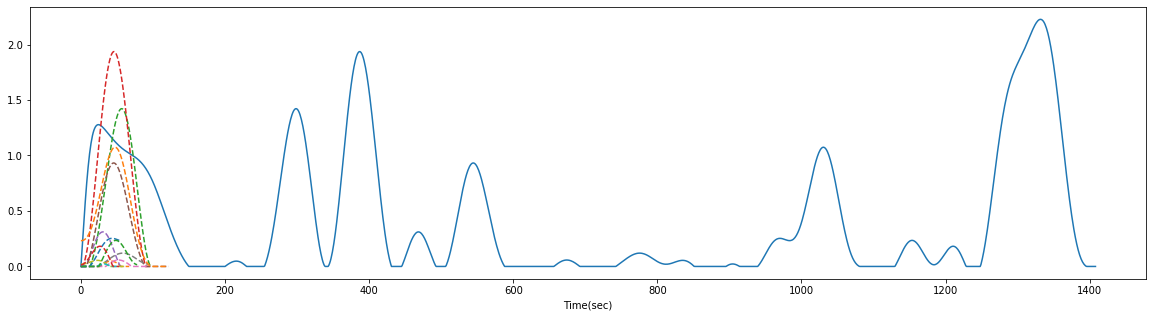

In [16]:
# dividere il segnale

plt.figure(figsize=(20,5))
plt.plot(x)

count=0
for i in range(0,13):
    phasic_atom = x[neg_peaks[count]:neg_peaks[count+1]]
    plt.plot(phasic_atom, '--')
    count=count+1


#phasic_atom_1 = x[neg_peaks[0]:neg_peaks[1]]
#plt.plot(phasic_atom_1, '--')
plt.xlabel('Time(sec)')
plt.show()

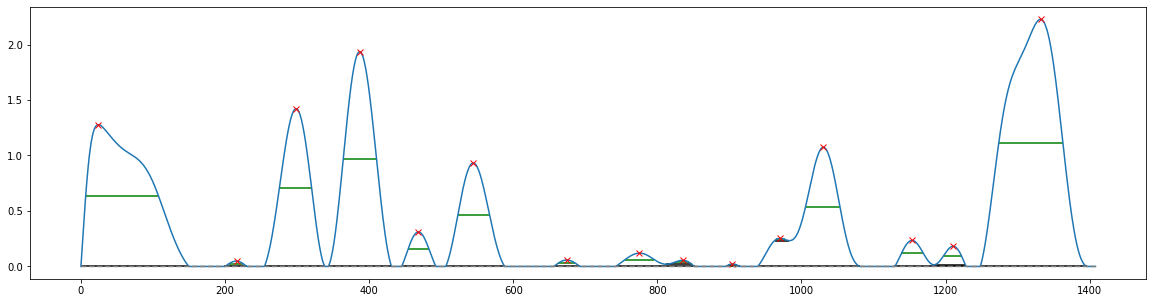

In [17]:
results_half = peak_widths(x, peaks, rel_height=0.5)
results_half[0]  # widths
results_full = peak_widths(x, peaks, rel_height=1)
results_full[0]  # widths

plt.figure(figsize=(20,5))
plt.plot(x)
plt.plot(peaks, x[peaks], "x", color='r')
plt.hlines(*results_half[1:], color="g")
plt.hlines(*results_full[1:], color="black")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

### PROVE

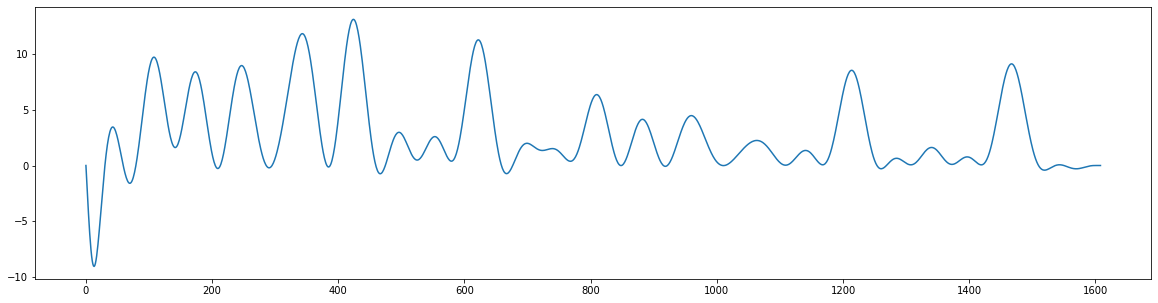

In [4]:
plt.figure(figsize=(20,5))
plt.plot(phasic)
plt.show()

In [3]:
# dividere il segnale in frames

foo = np.array(signal_p) # rendo il segnale un numpy array

# aggiungo tanti zeri alla fine per poter dividere in tot frame uguali da 128 l'uno
foo = np.pad(foo, (0, 54), 'constant')
foo = np.split(foo,13)

# senza aggiungere gli zeri in fondo, lasciando quindi l'ultimo frame più piccolo
#a = np.array_split(foo,13) # dimensione ogni frame 135, tranne ultimo 134 13
#b = np.pad(a)

M = np.array(foo)
print(M.shape)
print(M)

(13, 128)
[[ 8.08407  8.07339  8.0566  ... 11.647   11.7447  11.8499 ]
 [11.9247  12.0483  12.1414  ... 19.02    19.0429  19.0689 ]
 [19.0933  19.1177  19.1421  ... 16.7923  16.7556  16.7175 ]
 ...
 [ 8.67153  8.66085  8.64712 ...  7.34859  7.33791  7.32571]
 [ 7.32876  7.3135   7.29977 ...  8.14205  8.12984  8.12221]
 [ 8.0978   8.08102  8.07186 ...  0.       0.       0.     ]]


In [37]:
# preso un frame (es il primo), questo può essere rappresentato come un piccolo numero di atomi dal
# dizionario D tale che xn=D*cn dove cn sono i coefficienti degli atomi

x1 = M[0] 
print('first frame:\n', x1)
# selezione prima colonna M[:,0]

P = len(x1)
print('length of the frame: ', P)


# normalizzazione [0,1]
#x1 = (x1 - np.min(x1))/np.ptp(x1)
#print(x1)

first frame:
 [ 8.08407  8.07339  8.0566   8.04592  8.02303  8.00777  7.99862  7.98488
  7.97573  7.96047  7.94521  7.93911  7.92385  7.91012  7.90249  7.89791
  7.88723  7.8735   7.85976  7.85061  7.83993  7.82467  7.81246  7.80025
  7.78652  7.78957  7.77584  7.77431  7.78499  7.78957  7.80483  7.81246
  7.82925  7.85213  7.87655  7.89944  7.92538  7.96047  7.99862  8.03676
  8.07186  8.11916  8.16646  8.21529  8.26259  8.31753  8.36788  8.41366
  8.46249  8.51131  8.56319  8.60744  8.64864  8.69442  8.73104  8.77834
  8.81801  8.85769  8.876    8.91262  8.93703  8.95687  8.97518  8.99959
  9.0118   9.03927  9.05758  9.07284  9.10335  9.11404  9.1354   9.1476
  9.16134  9.18728  9.19338  9.20559  9.23     9.23458  9.25899  9.26967
  9.29104  9.30324  9.33376  9.35055  9.37191  9.39327  9.41921  9.44057
  9.46804  9.47872  9.50008  9.52602  9.56417  9.59011  9.62673  9.65114
  9.68471  9.72286  9.76101  9.7961   9.83578  9.86782  9.9136   9.95785
 10.0036  10.0509  10.1135  10.1669  1

In [38]:
# parametri per le funzioni

# phasic parameters
a = np.array([8, 14, 18]) # steepness of the onset
b = np.array([10, 15, 20]) # recovery
mu = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]) # time shift
s = np.array([0.100, 0.105, 0.110, 0.115, 0.120, 0.125, 0.130, 0.135, 0.140]) # scale

# creo un vettore con tutte le permutazioni di a,b,mu,s
phasic_vect = np.array(np.meshgrid(a,b,mu,s)).T.reshape(-1,4)

# tonic parameters
Gamma = np.array([-20, -10, 1]) # offset
Delta = np.array([-0.01, -0.009, -0.008, -0.007, -0.006, -0.005, -0.004, -0.003, -0.002, -0.001, 0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])

# creo un vettore con tutte le permutazioni di Gamma e Delta
tonic_vect = np.array(np.meshgrid(Gamma,Delta)).T.reshape(-1,2)

K1 = len(Gamma)*len(Delta)
K2 = len(a)*len(b)*len(mu)*len(s)
K = K1+K2

print('Gamma:', len(Gamma), 'Delta:', len(Delta), 'tonic atoms:', len(Gamma)*len(Delta))
print('a:', len(a), 'b:', len(b), 'mu:', len(mu), 's:', len(s), 'phasic atoms:', len(a)*len(b)*len(mu)*len(s))
print('tot atoms:', K)

Gamma: 3 Delta: 21 tonic atoms: 63
a: 3 b: 3 mu: 16 s: 9 phasic atoms: 1296
tot atoms: 1359


In [40]:
# il dizionario D è formato da K righe e P colonne
# ogni riga è un atomo, prima K1 tonic poi K2 phasic
# ogni colonna è un time instant del frame

D = np.zeros([K,P])
t = np.arange(0,P)

# popolo D con valori di atomi tonic
for row in range(0,K1):
    D[row,:] = tonic_vect[row,0]+tonic_vect[row,1]*t[:]

# popolo D con valori di atomi phasic
for row in range(K1,K):
    D[row,:] = np.exp(-phasic_vect[row-K1,1]*(phasic_vect[row-K1,3]*t[:]-phasic_vect[row-K1,2]))-np.exp(-phasic_vect[row-K1,0]*(phasic_vect[row-K1,3]*t[:]-phasic_vect[row-K1,2]))

        
print(tonic_vect.shape)
print(phasic_vect.shape)
print(D.shape)

(63, 2)
(1296, 4)
(1359, 128)


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in subtract
  


In [5]:
# prova con altri parametri

# parametri per le funzioni

# phasic parameters
a = np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]) # steepness of the onset
b = np.array([0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2]) # recovery
mu = np.array([0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310]) # time shift
s = np.array([0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14]) # scale

K2 = len(a)*len(b)*len(mu)*len(s)

phasic_vect = np.zeros([K2,4])

# creo un vettore con tutte le permutazioni di a,b,mu,s
phasic_vect = np.array(np.meshgrid(a,b,mu,s)).T.reshape(-1,4)

# rimuovo righe in cui a>b oppure per ogni riga in cui a<b popolo un nuovo vettore
pv=np.zeros([K2,4])
for ii in range(0,K2):
    if phasic_vect[ii,0]<phasic_vect[ii,1]:
        pv[ii,:]=phasic_vect[ii,:]

# rimuovo righe con zero
pv = pv[~np.all(pv == 0, axis=1)]
phasic_vect = pv

# tonic parameters
Gamma = np.array([-20,-10,1]) # offset
Delta = np.array([-0.01,-0.009,-0.008,-0.007,-0.006,-0.005,-0.004,-0.003,-0.002,-0.001,0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1])

# creo un vettore con tutte le permutazioni di Gamma e Delta
tonic_vect = np.array(np.meshgrid(Gamma,Delta)).T.reshape(-1,2)

K1 = len(Gamma)*len(Delta)
print('Gamma:', len(Gamma), 'Delta:', len(Delta), 'tonic atoms:', K1)
print('a:', len(a), 'b:', len(b), 'mu:', len(mu), 's:', len(s), 'phasic atoms:', K2, 'phasic atoms with a<b:',len(phasic_vect))
K2 = len(phasic_vect)
K = K1+K2
print('tot atoms:',K)

Gamma: 3 Delta: 21 tonic atoms: 63
a: 19 b: 9 mu: 32 s: 9 phasic atoms: 49248 phasic atoms with a<b: 25920
tot atoms: 25983


In [35]:
# il dizionario D è formato da K righe e P colonne
# ogni riga è un atomo, prima K1 tonic poi K2 phasic
# ogni colonna è un time instant del frame

D = np.zeros([K,P])
t = np.arange(0,P)

# popolo D con valori di atomi tonic
for row in range(0,K1):
    D[row,:] = tonic_vect[row,0]+tonic_vect[row,1]*t[:]

# popolo D con valori di atomi phasic
for row in range(K1,K):
    D[row,:] = np.exp(-phasic_vect[row-K1,1]*(phasic_vect[row-K1,3]*t[:]-phasic_vect[row-K1,2]))-np.exp(-phasic_vect[row-K1,0]*(phasic_vect[row-K1,3]*t[:]-phasic_vect[row-K1,2]))

        
print(tonic_vect.shape)
print(phasic_vect.shape)
print(D.shape)

(63, 2)
(25920, 4)
(25983, 128)


In [32]:
DT = D.transpose()
DT.shape

(128, 25983)